In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!java -version

openjdk version "11.0.19" 2023-04-18
OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)


In [30]:
!pip install pyspark

In [31]:
!pip install findspark

In [32]:
import findspark
findspark.init()
findspark.find()

'/usr/local/lib/python3.10/dist-packages/pyspark'

In [33]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()
emptyRDD = spark.sparkContext.emptyRDD()
print(emptyRDD)

EmptyRDD[140] at emptyRDD at NativeMethodAccessorImpl.java:0


In [34]:
data = [("Java", "20000"), ("Python", "100000"), ("Scala", "3000")]
columns = ["language", "users_count"]
df = spark.createDataFrame(data).toDF(*columns)
df.show()

+--------+-----------+
|language|users_count|
+--------+-----------+
|    Java|      20000|
|  Python|     100000|
|   Scala|       3000|
+--------+-----------+



In [35]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [36]:
file_path = "/content/drive/MyDrive/hackrx/"

In [37]:
from pyspark.sql import functions
from pyspark.sql import types

In [14]:
categories = spark.read.option("header",True).csv(file_path+'categories.csv')
info = spark.read.option("header",True).csv(file_path+'info.csv')
reviews = spark.read.option("header",True).csv(file_path+'reviews.csv')
similar = spark.read.option("header",True).csv(file_path+'similar.csv')

In [38]:
print(type(reviews))

<class 'pyspark.sql.dataframe.DataFrame'>


###User Charachteristics

Doing on small dataset containing 10000 items

In [39]:
"""
User charachteristics could contain:
  Customer_id
  group of purchase
  Voting Pattern
    Total votes on reviews
    Total helpful votes on reviews
"""


'\nUser charachteristics could contain:\n  Customer_id\n  group of purchase\n  Voting Pattern\n    Total votes on reviews\n    Total helpful votes on reviews\n'

In [40]:
reviews_red = reviews.limit(100)
info_red = info.limit(100)
cat_red = categories.limit(100)
print(f"Reviews DF size {reviews_red.count()} info DF size { info_red.count()} category Df size {cat_red.count()}")


Reviews DF size 100 info DF size 100 category Df size 100


In [41]:
cat_red = cat_red.withColumn("category", functions.split(functions.regexp_replace(functions.col("category"), r"\[.*?\]", ""), "\\|"))
cat_red.show(truncate=False)

+----------+--------------------------------------------------------------------------------------------------+
|ASIN      |category                                                                                          |
+----------+--------------------------------------------------------------------------------------------------+
|0827229534|[, Books, Subjects, Religion & Spirituality, Christianity, Clergy, Preaching]                     |
|0827229534|[, Books, Subjects, Religion & Spirituality, Christianity, Clergy, Sermons]                       |
|0738700797|[, Books, Subjects, Religion & Spirituality, Earth-Based Religions, Wicca]                        |
|0738700797|[, Books, Subjects, Religion & Spirituality, Earth-Based Religions, Witchcraft]                   |
|0486287785|[, Books, Subjects, Home & Garden, Crafts & Hobbies, General]                                     |
|0842328327|[, Books, Subjects, Religion & Spirituality, Christianity, Reference, Commentaries, New Test

In [42]:
def flatten_category(arr):
  return list(set(x.strip() for sublist in arr for x in sublist if x.strip()))

In [43]:
flattenUDF = functions.udf(lambda z: flatten_category(z), types.ArrayType(types.StringType()))

In [44]:
cat_red = cat_red.groupBy('ASIN').agg(functions.collect_set("category").alias("category"))
cat_red = cat_red.withColumn('category', flattenUDF(functions.col("category")))
cat_red.show(truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ASIN      |category                                                                                                                                                                                                                                                                                                                     |
+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|082722

In [45]:
reviews_red.show()

+----------+--------------+------+-----+-------+
|      ASIN|   customer id|rating|votes|helpful|
+----------+--------------+------+-----+-------+
|0827229534|A2JW67OY8U6HHK|     5|   10|      9|
|0827229534|A2VE83MZF98ITY|     5|    6|      5|
|0738700797|A11NCO6YTE4BTJ|     5|    5|      4|
|0738700797| A9CQ3PLRNIR83|     4|    5|      5|
|0738700797|A13SG9ACZ9O5IM|     5|    8|      8|
|0738700797|A1BDAI6VEYMAZA|     5|    4|      4|
|0738700797|A2P6KAWXJ16234|     4|   16|     16|
|0738700797| AMACWC3M7PQFR|     4|    5|      5|
|0738700797|A3GO7UV9XX14D8|     4|    6|      6|
|0738700797|A1GIL64QK68WKL|     5|    8|      8|
|0738700797| AEOBOF2ONQJWV|     5|    8|      5|
|0738700797|A3IGHTES8ME05L|     5|    5|      5|
|0738700797|A1CP26N8RHYVVO|     1|   13|      9|
|0738700797| ANEIANH0WAT9D|     5|    1|      1|
|0486287785|A3IDGASRQAW8B2|     5|    2|      2|
|0842328327|A2591BUPXCS705|     4|    1|      1|
|0486220125| ATVPDKIKX0DER|     5|   12|     11|
|0486220125| AUEZ7NV

In [46]:
reviews_red = reviews_red.drop("rating")

In [47]:
reviews_red.columns

['ASIN', 'customer id', 'votes', 'helpful']

In [25]:
reviews_red.show()

+----------+--------------+-----+-------+
|      ASIN|   customer id|votes|helpful|
+----------+--------------+-----+-------+
|0827229534|A2JW67OY8U6HHK|   10|      9|
|0827229534|A2VE83MZF98ITY|    6|      5|
|0738700797|A11NCO6YTE4BTJ|    5|      4|
|0738700797| A9CQ3PLRNIR83|    5|      5|
|0738700797|A13SG9ACZ9O5IM|    8|      8|
|0738700797|A1BDAI6VEYMAZA|    4|      4|
|0738700797|A2P6KAWXJ16234|   16|     16|
|0738700797| AMACWC3M7PQFR|    5|      5|
|0738700797|A3GO7UV9XX14D8|    6|      6|
|0738700797|A1GIL64QK68WKL|    8|      8|
|0738700797| AEOBOF2ONQJWV|    8|      5|
|0738700797|A3IGHTES8ME05L|    5|      5|
|0738700797|A1CP26N8RHYVVO|   13|      9|
|0738700797| ANEIANH0WAT9D|    1|      1|
|0486287785|A3IDGASRQAW8B2|    2|      2|
|0842328327|A2591BUPXCS705|    1|      1|
|0486220125| ATVPDKIKX0DER|   12|     11|
|0486220125| AUEZ7NVOEHYRY|   13|     12|
|0486220125| ATVPDKIKX0DER|   18|      7|
|0486220125| AJYG6ZJUQPZ9M|   14|     10|
+----------+--------------+-----+-

In [26]:
user_char = reviews_red.join(info_red,on="ASIN",how="inner")
user_char = user_char.join(cat_red, on="ASIN", how="inner")
user_char.show()

+----------+--------------+-----+-------+--------------------+-----+---------+--------------------+
|      ASIN|   customer id|votes|helpful|               title|group|salesrank|            category|
+----------+--------------+-----+-------+--------------------+-----+---------+--------------------+
|0827229534|A2JW67OY8U6HHK|   10|      9|Patterns of Preac...| Book|   396585|[Preaching, Chris...|
|0827229534|A2VE83MZF98ITY|    6|      5|Patterns of Preac...| Book|   396585|[Preaching, Chris...|
|0738700797|A11NCO6YTE4BTJ|    5|      4|Candlemas: Feast ...| Book|   168596|[Wicca, Books, Re...|
|0738700797| A9CQ3PLRNIR83|    5|      5|Candlemas: Feast ...| Book|   168596|[Wicca, Books, Re...|
|0738700797|A13SG9ACZ9O5IM|    8|      8|Candlemas: Feast ...| Book|   168596|[Wicca, Books, Re...|
|0738700797|A1BDAI6VEYMAZA|    4|      4|Candlemas: Feast ...| Book|   168596|[Wicca, Books, Re...|
|0738700797|A2P6KAWXJ16234|   16|     16|Candlemas: Feast ...| Book|   168596|[Wicca, Books, Re...|


In [27]:
user_char.count()

100

In [ ]:
user_char = user_char.drop("ASIN","title","salesrank")
user_char.show()

+--------------+-----+-------+-----+--------------------+
|   customer id|votes|helpful|group|            category|
+--------------+-----+-------+-----+--------------------+
|A2JW67OY8U6HHK|   10|      9| Book|[Preaching, Chris...|
|A2VE83MZF98ITY|    6|      5| Book|[Preaching, Chris...|
|A11NCO6YTE4BTJ|    5|      4| Book|[Wicca, Books, Re...|
| A9CQ3PLRNIR83|    5|      5| Book|[Wicca, Books, Re...|
|A13SG9ACZ9O5IM|    8|      8| Book|[Wicca, Books, Re...|
|A1BDAI6VEYMAZA|    4|      4| Book|[Wicca, Books, Re...|
|A2P6KAWXJ16234|   16|     16| Book|[Wicca, Books, Re...|
| AMACWC3M7PQFR|    5|      5| Book|[Wicca, Books, Re...|
|A3GO7UV9XX14D8|    6|      6| Book|[Wicca, Books, Re...|
|A1GIL64QK68WKL|    8|      8| Book|[Wicca, Books, Re...|
| AEOBOF2ONQJWV|    8|      5| Book|[Wicca, Books, Re...|
|A3IGHTES8ME05L|    5|      5| Book|[Wicca, Books, Re...|
|A1CP26N8RHYVVO|   13|      9| Book|[Wicca, Books, Re...|
| ANEIANH0WAT9D|    1|      1| Book|[Wicca, Books, Re...|
|A3IDGASRQAW8B

In [ ]:
user_char.select("customer id").distinct().count()

95

In [ ]:
user_char = user_char.groupBy("customer id").agg(functions.avg("votes").alias("avg_votes"),functions.avg("helpful").alias("avg_helpful_votes"),functions.collect_set("group").alias("group_set"),functions.collect_set("category").alias("category_set"))
user_char.show(truncate=False)

+--------------+---------+-----------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer id   |avg_votes|avg_helpful_votes|group_set    |category_set                                                                                                                                                                                                                                                                                                           |
+--------------+---------+-----------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
user_char = user_char.withColumn('category_set', flattenUDF(functions.col("category_set")))
user_char.show(truncate=False)

+--------------+---------+-----------------+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer id   |avg_votes|avg_helpful_votes|group_set    |category_set                                                                                                                                                                                                                                                         |
+--------------+---------+-----------------+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|A2JW67OY8U6HHK|10.0     |9.0        

In [ ]:
user_char.count()

95

###Item Charachteristics

Doing on small dataset containing 10000 items

In [ ]:
"""
Item charachteristics could contain:
  ASIN
  Title ??
  Group
  Sales Rank
  Similar Items ??
  Categories
  Avg Rating

PS: I am not sure whether title should be kept or not since ASIN should be enough. Not req then drop it
    I am also not sure how similar item can be encoporated in this, so i am just adding it as a list
"""

'\nItem charachteristics could contain:\n  ASIN\n  Title ??\n  Group\n  Sales Rank\n  Similar Items ??\n  Categories\n  Avg Rating\n\nPS: I am not sure whether title should be kept or not since ASIN should be enough. Not req then drop it\n    I am also not sure how similar item can be encoporated in this, so i am just adding it as a list\n'

In [ ]:
sim_red = similar.alias("sim_red")
reviews_red = reviews.alias("reviews_red")
cat_red = categories.alias("cat_red")

In [ ]:
cat_red = cat_red.withColumn("category", functions.split(functions.regexp_replace(functions.col("category"), r"\[.*?\]", ""), "\\|"))
cat_red.show(truncate=False)

+----------+--------------------------------------------------------------------------------------------------+
|ASIN      |category                                                                                          |
+----------+--------------------------------------------------------------------------------------------------+
|0827229534|[, Books, Subjects, Religion & Spirituality, Christianity, Clergy, Preaching]                     |
|0827229534|[, Books, Subjects, Religion & Spirituality, Christianity, Clergy, Sermons]                       |
|0738700797|[, Books, Subjects, Religion & Spirituality, Earth-Based Religions, Wicca]                        |
|0738700797|[, Books, Subjects, Religion & Spirituality, Earth-Based Religions, Witchcraft]                   |
|0486287785|[, Books, Subjects, Home & Garden, Crafts & Hobbies, General]                                     |
|0842328327|[, Books, Subjects, Religion & Spirituality, Christianity, Reference, Commentaries, New Test

In [ ]:
cat_red = cat_red.groupBy('ASIN').agg(functions.collect_set("category").alias("category"))
cat_red = cat_red.withColumn('category', flattenUDF(functions.col("category")))
cat_red.show(truncate=False)

+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ASIN      |category                                                                                                                                                                                                             |
+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0001057170|[Humor, Entertainment, Books, Formats, General, Boxed Sets, Books on Tape, Subjects]                                                                                                                                 |
|0001474103|[Christianity, Books, Religion & Spirituality, Prophecies, Subjects, Reference] 

In [ ]:
sim_red.show()

+----------+----------+
|      ASIN|   ASIN ID|
+----------+----------+
|0827229534|0804215715|
|0827229534|156101074X|
|0827229534|0687023955|
|0827229534|0687074231|
|0827229534|082721619X|
|0738700797|0738700827|
|0738700797|1567184960|
|0738700797|1567182836|
|0738700797|0738700525|
|0738700797|0738700940|
|0842328327|0842328130|
|0842328327|0830818138|
|0842328327|0842330313|
|0842328327|0842328610|
|0842328327|0842328572|
|1577943082|157794349X|
|1577943082|0892749504|
|1577943082|1577941829|
|1577943082|0892749563|
|1577943082|1577946006|
+----------+----------+
only showing top 20 rows



In [ ]:
sim_red = sim_red.groupBy("ASIN").agg(functions.collect_list("ASIN ID").alias("similar_set"))
sim_red.show()
sim_red.count()

+----------+--------------------+
|      ASIN|         similar_set|
+----------+--------------------+
|0001057170|[B00006JMQR, 1585...|
|0001474103|[0895403889, 0001...|
|0002250985|[0912365307, 0060...|
|0002251965|[0002553481, 0002...|
|0004722817|[0007127596, 0004...|
|0004724534|[0007127596, 0007...|
|0006386709|[1857883195, 0060...|
|0006482848|[1400030137, 1400...|
|0006482864|[1400030080, 1400...|
|0006491790|[0865475091, 0151...|
|0006531806|[0030635543, 1891...|
|0007105509|[0743427084, 1573...|
|0007116012|[1573221112, 0743...|
|0007116993|[014219624X, 0722...|
|0007117000|[0062513605, 1577...|
|0007127952|[0399144374, 0425...|
|0007131151|[0722535724, 1567...|
|0007140444|[0285633791, 0960...|
|0007142595|[0261103881, 0007...|
|002011690X|[0307605817, 0943...|
+----------+--------------------+
only showing top 20 rows



63780

In [ ]:
info_red.show()

+----------+--------------------+-----+---------+
|      ASIN|               title|group|salesrank|
+----------+--------------------+-----+---------+
|0827229534|Patterns of Preac...| Book|   396585|
|0738700797|Candlemas: Feast ...| Book|   168596|
|0486287785|World War II Alli...| Book|  1270652|
|0842328327|Life Application ...| Book|   631289|
|1577943082|Prayers That Avai...| Book|   455160|
|0486220125|How the Other Hal...| Book|   188784|
|B00000AU3R|               Batik|Music|     5392|
|0231118597| Losing Matt Shepard| Book|   277409|
|1859677800|Making Bread: The...| Book|   949166|
|0375709363|The Edward Said R...| Book|   220379|
|0871318237|Resetting the Clo...| Book|   412962|
|1590770218|Fantastic Food wi...| Book|    24741|
|0313230269|Clockwork Worlds ...| Book|  2895088|
|B00004W1W1|            Later...|Music|   390624|
|1559362022|Wake Up and Smell...| Book|   518927|
|0195110382|War at Sea: A Nav...| Book|   631564|
|0849311012|Telecommunication...| Book|   570183|


In [ ]:
reviews_red.show()

+----------+--------------+------+-----+-------+
|      ASIN|   customer id|rating|votes|helpful|
+----------+--------------+------+-----+-------+
|0827229534|A2JW67OY8U6HHK|     5|   10|      9|
|0827229534|A2VE83MZF98ITY|     5|    6|      5|
|0738700797|A11NCO6YTE4BTJ|     5|    5|      4|
|0738700797| A9CQ3PLRNIR83|     4|    5|      5|
|0738700797|A13SG9ACZ9O5IM|     5|    8|      8|
|0738700797|A1BDAI6VEYMAZA|     5|    4|      4|
|0738700797|A2P6KAWXJ16234|     4|   16|     16|
|0738700797| AMACWC3M7PQFR|     4|    5|      5|
|0738700797|A3GO7UV9XX14D8|     4|    6|      6|
|0738700797|A1GIL64QK68WKL|     5|    8|      8|
|0738700797| AEOBOF2ONQJWV|     5|    8|      5|
|0738700797|A3IGHTES8ME05L|     5|    5|      5|
|0738700797|A1CP26N8RHYVVO|     1|   13|      9|
|0738700797| ANEIANH0WAT9D|     5|    1|      1|
|0486287785|A3IDGASRQAW8B2|     5|    2|      2|
|0842328327|A2591BUPXCS705|     4|    1|      1|
|0486220125| ATVPDKIKX0DER|     5|   12|     11|
|0486220125| AUEZ7NV

In [ ]:
reviews_red = reviews_red.drop("customer id", "votes", "helpful")
reviews_red.show()

+----------+------+
|      ASIN|rating|
+----------+------+
|0827229534|     5|
|0827229534|     5|
|0738700797|     5|
|0738700797|     4|
|0738700797|     5|
|0738700797|     5|
|0738700797|     4|
|0738700797|     4|
|0738700797|     4|
|0738700797|     5|
|0738700797|     5|
|0738700797|     5|
|0738700797|     1|
|0738700797|     5|
|0486287785|     5|
|0842328327|     4|
|0486220125|     5|
|0486220125|     5|
|0486220125|     5|
|0486220125|     4|
+----------+------+
only showing top 20 rows



In [ ]:
reviews_red = reviews_red.groupBy("ASIN").agg(functions.avg("rating").alias("avg_rating"))
reviews_red.show()

+----------+------------------+
|      ASIN|        avg_rating|
+----------+------------------+
|B00000IBNZ|               4.0|
|0425182681|3.4545454545454546|
|B00005YTRK|               5.0|
|0805044108|               5.0|
|092997929X|               5.0|
|0970430353|             4.625|
|1564145743|3.8333333333333335|
|0531164659|               5.0|
|0071346503|               4.2|
|B00000JMXK|               5.0|
|1575846578|               5.0|
|0140447881|               3.5|
|0912912065| 4.511111111111111|
|0786865059|3.8106796116504853|
|050051044X|               3.5|
|B00003CK6Y|              4.75|
|B000053VCO|               4.0|
|B00005T30X|             1.875|
|B000000PEZ|               5.0|
|B000059HUN| 4.666666666666667|
+----------+------------------+
only showing top 20 rows



In [ ]:
reviews_red.count()

66991

In [ ]:
item_char = reviews_red.join(info_red,on="ASIN",how="inner")
item_char.show()
item_char.count()

+----------+------------------+--------------------+-----+---------+
|      ASIN|        avg_rating|               title|group|salesrank|
+----------+------------------+--------------------+-----+---------+
|0786863919| 4.666666666666667|Disney A to Z : T...| Book|   161879|
|0439240751|               5.0|Double Jeopardy (...| Book|    97166|
|0689846088|               3.0|A Charlie Brown C...| Book|   423424|
|0393037622|               4.0|Blood and Guts: A...| Book|   408761|
|0875420532| 4.333333333333333|Secrets of Gypsy ...| Book|   409481|
|0944708498|               5.0|Baby Boomer Retir...| Book|   566643|
|0231118597| 4.466666666666667| Losing Matt Shepard| Book|   277409|
|0375709363|               4.0|The Edward Said R...| Book|   220379|
|B000002O8D| 4.166666666666667|Southern By the G...|Music|    89264|
|3895780812|               5.0|Computed Tomograp...| Book|   179448|
|0393049388|               3.0|Strange Fire: A N...| Book|  1277867|
|1566913810|               3.5|Fog

73

In [ ]:
item_char.filter(item_char["ASIN"]== "3895780812").show()

+----------+----------+--------------------+-----+---------+
|      ASIN|avg_rating|               title|group|salesrank|
+----------+----------+--------------------+-----+---------+
|3895780812|       5.0|Computed Tomograp...| Book|   179448|
+----------+----------+--------------------+-----+---------+



In [ ]:
cat_red.show()

+----------+--------------------+
|      ASIN|            category|
+----------+--------------------+
|0001057170|[Humor, Entertain...|
|0001474103|[Christianity, Bo...|
|0002193183|[Biological Scien...|
|0002250985|[Food & Wine, Bru...|
|0002251965|[U.S. Regional, F...|
|0004133897|[Arts & Photograp...|
|0004140885|[Food & Wine, Boo...|
|0004707508|[English (All), I...|
|0004722817|[Conventional, Wo...|
|0004723015|[Individual Sport...|
|0004723996|[Travel Books, Gr...|
|0004724534|[Antiques & Colle...|
|000472500X|[Arts & Photograp...|
|0005993806|[Christianity, Ch...|
|0006386709|[Business & Inves...|
|0006482864|[Dick, ( D ), Sci...|
|0006491790|[Water Sports, Su...|
|0006498779|[Mystery, Mystery...|
|0006531806|[Strategy, Politi...|
|0006907237|[Fiction, Science...|
+----------+--------------------+
only showing top 20 rows



In [ ]:
item_char = item_char.join(cat_red,on="ASIN",how="inner")
item_char.show(truncate=False)
item_char.count()

+----------+------------------+--------------------------------------------------------------------------------------------+-----+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ASIN      |avg_rating        |title                                                                                       |group|salesrank|category                                                                                                                                                                                                                                  |
+----------+------------------+--------------------------------------------------------------------------------------------+-----+---------+------------------------------------------------------------------------------------------------------------

73

In [ ]:
item_char = item_char.join(sim_red,on="ASIN",how="inner")
item_char.show(truncate=False)
item_char.count()

+----------+------------------+-----------------------------------------------------------------------------------------------------------------------------+-----+---------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------+
|ASIN      |avg_rating        |title                                                                                                                        |group|salesrank|category                                                                                                                                                                                                                                                                           

63

###Graph Embedding

In [ ]:
!pip install node2vec

In [ ]:
len(user1_embedding)

64

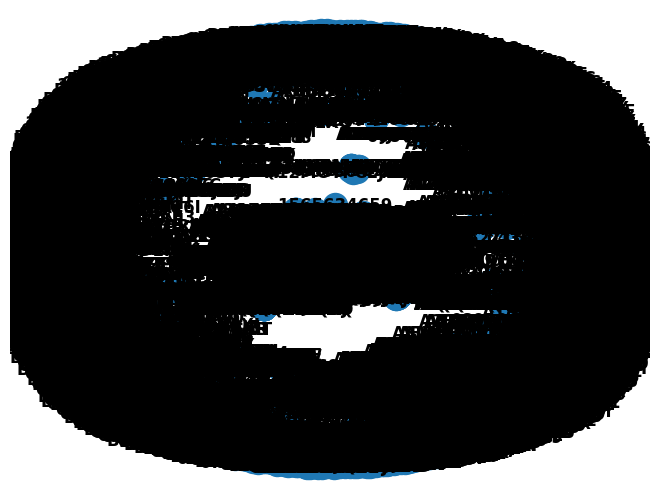

In [ ]:
nx.draw(graph,with_labels=True, font_weight='bold')

In [ ]:
user_char.show(truncate=False)

+--------------+---------+-----------------+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer id   |avg_votes|avg_helpful_votes|group_set    |category_set                                                                                                                                                                                                                                                         |
+--------------+---------+-----------------+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|A2JW67OY8U6HHK|10.0     |9.0        

In [ ]:
user_dat = user_char.drop('avg_votes','avg_helpful_votes','group_set',)
user_dat.show(truncate=False)

+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer id   |category_set                                                                                                                                                                                                                                                         |
+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|A2JW67OY8U6HHK|[Preaching, Christianity, Books, Sermons, Clergy, Religion & Spirituality, Subjects]                                                               

In [ ]:
item_dat = item_char.drop('avg_rating','group','salesrank')
item_dat.show(truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------+
|ASIN      |title                                                                                                                        |category                                                                                                                                                                                                                                                                                                                    |similar_set                 

In [ ]:
user_characteristics = user_dat.rdd.map(lambda row: (row['customer id'], row['category_set'])).collectAsMap()
print(user_characteristics)


{'A2JW67OY8U6HHK': ['Preaching', 'Christianity', 'Books', 'Sermons', 'Clergy', 'Religion & Spirituality', 'Subjects'], 'A2VE83MZF98ITY': ['Preaching', 'Christianity', 'Books', 'Sermons', 'Clergy', 'Religion & Spirituality', 'Subjects'], 'A11NCO6YTE4BTJ': ['Witchcraft', 'Books', 'Religion & Spirituality', 'Earth-Based Religions', 'Subjects', 'Wicca'], 'A9CQ3PLRNIR83': ['Witchcraft', 'Books', 'Religion & Spirituality', 'Earth-Based Religions', 'Subjects', 'Wicca'], 'A13SG9ACZ9O5IM': ['Witchcraft', 'Books', 'Religion & Spirituality', 'Earth-Based Religions', 'Subjects', 'Wicca'], 'A1BDAI6VEYMAZA': ['Witchcraft', 'Books', 'Religion & Spirituality', 'Earth-Based Religions', 'Subjects', 'Wicca'], 'A2P6KAWXJ16234': ['Witchcraft', 'Books', 'Religion & Spirituality', 'Earth-Based Religions', 'Subjects', 'Wicca'], 'AMACWC3M7PQFR': ['Witchcraft', 'Books', 'Religion & Spirituality', 'Earth-Based Religions', 'Subjects', 'Wicca'], 'A3GO7UV9XX14D8': ['Witchcraft', 'Books', 'Religion & Spirituality', 

In [ ]:
item_characteristics = item_dat.rdd.map(lambda row: (row['ASIN'], row['category'])).collectAsMap()
print(item_characteristics)

{'0113300174': ['Company Profiles', 'Business & Investing Books', 'Management & Leadership', 'Amazon.com Stores', 'Books', 'Business & Investing', 'General', 'Biographies & Primers', 'Management Science', 'Home & Office', 'Subjects', 'Reference'], '0231096704': ['Special Groups', 'Nonfiction', 'Books', 'Social Sciences', 'General', 'Gay & Lesbian', 'Literature & Fiction', 'Classics', 'Lesbian Studies', 'Subjects'], '0231118597': ['Criminology', 'Crime & Criminals', 'Politics', 'Nonfiction', 'Books', 'General', 'Gay & Lesbian', 'U.S.', 'Subjects'], '0312199406': ['Contemporary', 'Books', 'Popular Fiction', 'General', 'Book Clubs', 'Specialty Stores', 'Literature & Fiction', 'Subjects'], '0312982178': ['Mystery', 'Mystery & Thrillers', 'Books', 'General', 'Subjects'], '0375709363': ['History & Criticism', 'Criticism & Theory', 'Politics', 'Nonfiction', 'Anthropology', 'Books', 'Social Sciences', 'Cultural', 'General', 'Literature & Fiction', 'History & Theory', 'Subjects'], '0393037622':

In [ ]:
reviews_red = reviews.limit(10000)

In [ ]:
edge_table.show()

+----------+--------------+
|      ASIN|   customer id|
+----------+--------------+
|0827229534|A2JW67OY8U6HHK|
|0827229534|A2VE83MZF98ITY|
|0738700797|A11NCO6YTE4BTJ|
|0738700797| A9CQ3PLRNIR83|
|0738700797|A13SG9ACZ9O5IM|
|0738700797|A1BDAI6VEYMAZA|
|0738700797|A2P6KAWXJ16234|
|0738700797| AMACWC3M7PQFR|
|0738700797|A3GO7UV9XX14D8|
|0738700797|A1GIL64QK68WKL|
|0738700797| AEOBOF2ONQJWV|
|0738700797|A3IGHTES8ME05L|
|0738700797|A1CP26N8RHYVVO|
|0738700797| ANEIANH0WAT9D|
|0486287785|A3IDGASRQAW8B2|
|0842328327|A2591BUPXCS705|
|0486220125| ATVPDKIKX0DER|
|0486220125| AUEZ7NVOEHYRY|
|0486220125| ATVPDKIKX0DER|
|0486220125| AJYG6ZJUQPZ9M|
+----------+--------------+
only showing top 20 rows



In [ ]:
import networkx as nx

# Create a new bipartite graph
graph = nx.Graph()

# Add users as nodes in one set
graph.add_nodes_from(user_characteristics.keys(), bipartite=0)

# Add items as nodes in the other set
graph.add_nodes_from(item_characteristics.keys(), bipartite=1)

# Add edges between users and items based on shared characteristics
# for user, user_char in user_characteristics.items():
#     for item, item_char in item_characteristics.items():
#         if any(char in user_char for char in item_char):
#             graph.add_edge(user, item)
for row in edge_table.collect():
    customer_id = row['customer id']
    ASIN = row['ASIN']
    graph.add_edge(customer_id,ASIN)

ValueError: ignored

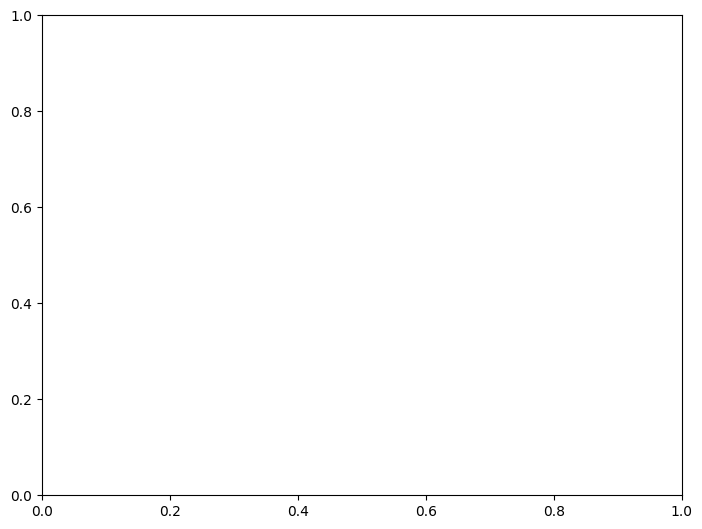

In [ ]:
nx.draw(graph,with_label=True)

In [ ]:
count = 0
for n,d in list(graph.nodes(data=True)):
  if len(d) == 0:
    print(n)
    count+=1

print(count)

In [ ]:
import networkx as nx

# Create a new bipartite graph
graph = nx.Graph()

# Add users as nodes in one set
graph.add_nodes_from(user_characteristics.keys(), bipartite=0)

# Add items as nodes in the other set
graph.add_nodes_from(item_characteristics.keys(), bipartite=1)

# Add edges between users and items based on shared characteristics
# for user, user_char in user_characteristics.items():
#     for item, item_char in item_characteristics.items():
#         if any(char in user_char for char in item_char):
#             graph.add_edge(user, item)
for row in edge_table.collect():
    customer_id = row['customer id']
    ASIN = row['ASIN']
    graph.add_edge(customer_id,ASIN)

# Access nodes and edges
user_nodes = {n for n, d in graph.nodes(data=True) if len(d)!=0 and d['bipartite'] == 0}
item_nodes = {n for n, d in graph.nodes(data=True) if len(d)!=0 and d['bipartite'] == 1}
edges = graph.edges()

# Perform node embedding
# Node embedding is a way to represent nodes in a low-dimensional vector space
# There are several algorithms available for node embedding, such as node2vec, DeepWalk, or GraphSAGE.
# Here's an example of using the node2vec algorithm from the `node2vec` library in Python:

from node2vec import Node2Vec

# Create the Node2Vec object
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Generate the node embeddings
model = node2vec.fit(window=10, min_count=1)

# Get the embedding vectors for users and items
user_embeddings = {node: model.wv[node] for node in user_nodes}
item_embeddings = {node: model.wv[node] for node in item_nodes}

# Now you have the node embeddings for users and items, which you can use for various downstream tasks.

# Example usage:
# You can calculate the similarity between two nodes based on their embeddings
# user1_embedding = user_embeddings["user1"]
# item1_embedding = item_embeddings["item1"]
# similarity = user1_embedding.dot(item1_embedding)

In [ ]:
nx.draw(graph,with_labels=True, font_weight='bold')

In [ ]:
import networkx as nx

# Example user and item characteristics
user_characteristics = {
    "user1": ["good", "handsome"],
    "user2": ["angry", "tall"],
    # Add more users and their characteristics
}

item_characteristics = {
    "item1": ["best", "short"],
    "item2": ["shine", "bad"],
    # Add more items and their characteristics
}

# Create a new bipartite graph
graph = nx.Graph()

# Add users as nodes in one set
graph.add_nodes_from(user_characteristics.keys(), bipartite=0)

# Add items as nodes in the other set
graph.add_nodes_from(item_characteristics.keys(), bipartite=1)

# Add edges between users and items based on shared characteristics
# for user, user_char in user_characteristics.items():
#     for item, item_char in item_characteristics.items():
#         if any(char in user_char for char in item_char):
#             graph.add_edge(user, item)
graph.add_edge("user1","item2")
graph.add_edge("user2","item1")

# Access nodes and edges
user_nodes = {n for n, d in graph.nodes(data=True) if d["bipartite"] == 0}
item_nodes = {n for n, d in graph.nodes(data=True) if d["bipartite"] == 1}
edges = graph.edges()

# Perform node embedding
# Node embedding is a way to represent nodes in a low-dimensional vector space
# There are several algorithms available for node embedding, such as node2vec, DeepWalk, or GraphSAGE.
# Here's an example of using the node2vec algorithm from the `node2vec` library in Python:

from node2vec import Node2Vec

# Create the Node2Vec object
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Generate the node embeddings
model = node2vec.fit(window=10, min_count=1)

# Get the embedding vectors for users and items
user_embeddings = {node: model.wv[node] for node in user_nodes}
item_embeddings = {node: model.wv[node] for node in item_nodes}

# Now you have the node embeddings for users and items, which you can use for various downstream tasks.

# Example usage:
# You can calculate the similarity between two nodes based on their embeddings
user1_embedding = user_embeddings["user1"]
item1_embedding = item_embeddings["item1"]
similarity = user1_embedding.dot(item1_embedding)


In [ ]:
print(user)